In [1]:
%install-location $cwd/installed-packages
%install '.package(path: "$cwd/exports/e_00_MNISTLoader")' e_00_MNISTLoader

Installing packages:
	.package(path: "/home/alex/Desktop/ML/AI-Abstraction/swift/notebooks/exports/e_00_MNISTLoader")
		e_00_MNISTLoader
With SwiftPM flags: []
Working in: /tmp/tmpep3uyps0/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
import TensorFlow
import e_00_MNISTLoader

#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")

func plotMNIST<T : NumpyScalarCompatible>(x : Tensor<T>) {
    let img = x.makeNumpyArray().reshape(28, 28)
    plt.figure(figsize: [5, 5])
    plt.show(
        plt.imshow(img, cmap: "cool")
    )   
}

In [3]:
let (xTrain, yTrain, xValid, yValid) = loadMNIST(path: MNISTPath)

In [4]:
public struct DatasetV2<Tx : TensorFlowScalar, Ty : TensorFlowScalar> {
    
    public typealias XData = Tensor<Tx>
    public typealias YData = Tensor<Ty>
    
    let x : XData
    let y : YData
    let count : Int
    
    public init(x xIn: XData, y yIn: YData) {
        (x, y) = (xIn, yIn)
        count = x.shape[0]
    }
    
    subscript(_ i: Int) -> (XData, YData) {
        return (x[i], y[i])
    }
}

In [5]:
public struct DataLoader<Tx : TensorFlowScalar, Ty : TensorFlowScalar> {
    
    public typealias DS = DatasetV2<Tx, Ty>
    
    let dataset   : DS
    let batchSize : Int
    let shuffle   : Bool
    
    public init(dataset ds: DS, batchSize bs: Int, shuffle shuf: Bool = false) {
        (dataset, batchSize, shuffle) = (ds, bs, shuf)
    }
    
    public func inBatches() -> ([Tensor<Tx>], [Tensor<Ty>]) {
        let numBatches = [dataset.count / batchSize]
        let lastBatchSize = Tensor([Int32(dataset.count % batchSize)])

        let splits = Tensor<Int32>([Int32(batchSize)])
                        .tiled(multiples: numBatches)
                        .concatenated(with: lastBatchSize)   
        
        let parts = (dataset.x.split(sizes: splits, alongAxis: 0), dataset.y.split(sizes: splits, alongAxis: 0))
        
        return parts
    }
    
}

In [6]:
var dataset = DatasetV2(x: xTrain, y: yTrain)
dataset.count

60000


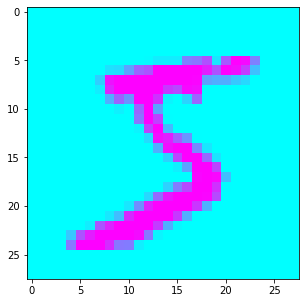

In [7]:
plotMNIST(x: dataset[0].0)

In [8]:
var dataLoader = DataLoader(dataset: dataset, batchSize: 64)
let batches = dataLoader.inBatches()

In [ ]:
// let hiddenSize: Int = 50

// struct SequentialModel<T: TensorFlowScalar> : Layer {
//     var layers = [
//       Dense<T>(inputSize: 4, outputSize: hiddenSize, activation: relu),
//       Dense<T>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu),
//       Dense<T>(inputSize: hiddenSize, outputSize: 3)
//    ]
//     // var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
//     // var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
//     // var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
//     @differentiable
//     func callAsFunction(_ input: Tensor<T>) -> Tensor<T> {
//       return forward(input)
//     }

//     @differentiable
//     func forward(_ input: Tensor<T>, _ i: Int = 0) -> Tensor<T> {
//       if i == layers.count-1 {
//         return layers[i](input)
//       } else {
//         return forward(layers[i](input), i+1)
//       }
//     }
// }

In [12]:
let hiddenSize: Int = 50
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 784, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 10)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

In [16]:
let optimizer = SGD(for: model, learningRate: 0.01)

for i in 0..<batches.0.count {
    let xBatch = batches.0[i]
                .reshaped(to: [batches.0[i].shape[0], 784])
    let yBatch = batches.1[i]
    
    let preds = model(xBatch)
    let (loss, grads) = valueWithGradient(at: model) { model -> Tensor<Float> in
        let logits = model(xBatch)
        return softmaxCrossEntropy(logits: logits, labels: yBatch)
    }
    print("Current loss: \(loss)")
    
    optimizer.update(&model, along: grads)
}

Current loss: 0.513113
Current loss: 0.34544513
Current loss: 0.5885688
Current loss: 0.4210691
Current loss: 0.3851347
Current loss: 0.2701551
Current loss: 0.40246576
Current loss: 0.5511909
Current loss: 0.4075188
Current loss: 0.6296403
Current loss: 0.43474358
Current loss: 0.38124093
Current loss: 0.4195974
Current loss: 0.6266251
Current loss: 0.57821697
Current loss: 0.49760997
Current loss: 0.67253214
Current loss: 0.722686
Current loss: 0.27149516
Current loss: 0.6742519
Current loss: 0.4519796
Current loss: 0.6525893
Current loss: 0.39452732
Current loss: 0.41823786
Current loss: 0.49471003
Current loss: 0.43321612
Current loss: 0.3268866
Current loss: 0.36025512
Current loss: 0.3985387
Current loss: 0.3189929
Current loss: 0.34022895
Current loss: 0.4115391
Current loss: 0.36645052
Current loss: 0.30113798
Current loss: 0.4144564
Current loss: 0.31871873
Current loss: 0.3068427
Current loss: 0.5920725
Current loss: 0.348953
Current loss: 0.35730678
Current loss: 0.31760213


Current loss: 0.36753175
Current loss: 0.63191605
Current loss: 0.2616218
Current loss: 0.46519616
Current loss: 0.36336526
Current loss: 0.49882394
Current loss: 0.43079698
Current loss: 0.28710538
Current loss: 0.28911868
Current loss: 0.467428
Current loss: 0.5062867
Current loss: 0.3421405
Current loss: 0.3318203
Current loss: 0.42812636
Current loss: 0.49874866
Current loss: 0.5621971
Current loss: 0.44528964
Current loss: 0.5055601
Current loss: 0.4923639
Current loss: 0.28516713
Current loss: 0.45915985
Current loss: 0.41597766
Current loss: 0.24712676
Current loss: 0.42185253
Current loss: 0.33722723
Current loss: 0.3767145
Current loss: 0.54836696
Current loss: 0.20818855
Current loss: 0.21724457
Current loss: 0.30481523
Current loss: 0.37569577
Current loss: 0.30277348
Current loss: 0.27751085
Current loss: 0.304625
Current loss: 0.51385856
Current loss: 0.2947647
Current loss: 0.37088776
Current loss: 0.24970554
Current loss: 0.32912675
Current loss: 0.25895548
Current loss:

Current loss: 0.47473875
Current loss: 0.580036
Current loss: 0.43909442
Current loss: 0.47055686
Current loss: 0.21205609
Current loss: 0.28040686
Current loss: 0.31346607
Current loss: 0.19577368
Current loss: 0.39686984
Current loss: 0.19744423
Current loss: 0.3112808
Current loss: 0.30264962
Current loss: 0.38736695
Current loss: 0.2359173
Current loss: 0.27390826
Current loss: 0.372729
Current loss: 0.4724331
Current loss: 0.40120882
Current loss: 0.325331
Current loss: 0.455391
Current loss: 0.21087123
Current loss: 0.62325716
Current loss: 0.29344764
Current loss: 0.36635554
Current loss: 0.37277016
Current loss: 0.19635418
Current loss: 0.497526
Current loss: 0.4808696
Current loss: 0.20826195
Current loss: 0.269054
Current loss: 0.18264593
Current loss: 0.17874643
Current loss: 0.27912217
Current loss: 0.5539192
Current loss: 0.29361638
Current loss: 0.22745736
Current loss: 0.37643194
Current loss: 0.2676927
Current loss: 0.27948698
Current loss: 0.22519135
Current loss: 0.20